In [ ]:
!pip install pyspark

Clean and transform data

In [3]:
from pyspark.sql.functions import desc, collect_list, struct, col, to_json, when, regexp_replace, translate, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql import SparkSession, DataFrame
from functools import reduce 
import zipfile
import io

spark = SparkSession.builder\
        .master("local[1]")\
        .appName("SparkReadCSVExample")\
        .getOrCreate()    

zip_path = './content/drive/download.zip'
unzip_path = './content/files'

zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall(unzip_path)
zip_ref.close()

file_dict= {
  spark.read.options(header='True', inferSchema='True')\
            .csv(unzip_path+'/A_lvr_land_A.csv'): '臺北市',
  spark.read.options(header='True', inferSchema='True')\
            .csv(unzip_path+'/F_lvr_land_A.csv'): '新北市',
  spark.read.options(header='True', inferSchema='True')\
            .csv(unzip_path+'/H_lvr_land_A.csv'): '桃園市',
  spark.read.options(header='True', inferSchema='True')\
            .csv(unzip_path+'/B_lvr_land_A.csv'): '台中市',
  spark.read.options(header='True', inferSchema='True')\
            .csv(unzip_path+'/E_lvr_land_A.csv'): '高雄市'
}

#add city column
df_list = []
for item in file_dict:
  df_list.append(
      item.withColumn('city',\
           when((item.土地位置建物門牌[0:3] == file_dict[item]), item.土地位置建物門牌[0:3])\
          .otherwise(file_dict[item]))
  )

#marge dataframe by spark
spark_df = reduce(DataFrame.unionAll, df_list)

#remove english row
spark_df = spark_df.where('`鄉鎮市區` not like "The villages%"')

spark_df = spark_df.withColumn('floor_num',\
            when(spark_df.總樓層數.endswith('層'), regexp_replace(spark_df.總樓層數,'層',''))\
           .otherwise('')
       )


In [4]:
def covert_num(floor_name):
    result = 0
    if isinstance(floor_name, int):
        return floor_name

    if isinstance(floor_name, float):
        result = int(floor_name)
        return result

    # List of words
    num_list = {"一": 1, "二": 2, "三": 3, "四": 4, "五": 5,
                "六": 6, "七": 7, "八": 8, "九": 9, "十": 10}

    for i in range(0, len(floor_name)):
        for k in num_list:
            if len(floor_name) == 1:
                if (k == floor_name[i]):
                    result = num_list[k]
            elif len(floor_name) == 2:
                if (k == floor_name[0]):
                    result = num_list[k] + num_list[floor_name[1]]
                else:
                    result = num_list[floor_name[0]] * 10
            elif len(floor_name) == 3:
                if (k == floor_name[1]):
                    result = num_list[floor_name[0]] * \
                        10 + num_list[floor_name[2]]
                else:
                    result = 0
        return result

def convert_western_date(date):
    if len(date) == 7:
      year = str(int(date[0:3])+1911)
      month = date[3:5]
      day = date[5:7]
    else: 
      year = str(int(date[0:2])+1911)
      month = date[2:4]
      day = date[4:6]
    date = year + "-" + month + "-" + day
    return date

num_udf = udf(covert_num, IntegerType())
western_date_udf = udf(convert_western_date, StringType())

spark_df = spark_df.withColumn("floor_num", num_udf(col("floor_num")))
spark_df = spark_df.withColumn("交易年月日", western_date_udf(col("交易年月日")))

In [ ]:
#Download Traditional Chinese Font
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

In [270]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from matplotlib.font_manager import fontManager as font_manager
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings('ignore')

zh_font=mpl.font_manager.FontProperties(fname=r'/content/TaipeiSansTCBeta-Regular.ttf')

%matplotlib inline
pd.options.mode.chained_assignment = None

mpl.matplotlib_fname()

'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [271]:
data = spark_df.toPandas()
data.fillna(0)
data['交易年月日'] = data['交易年月日'].astype('datetime64[ns]')
data['year'] = data['交易年月日'].dt.year
data['month'] = data['交易年月日'].dt.month
data['總價元'] = data['總價元'].astype(int)
data['土地移轉總面積平方公尺'] = data['土地移轉總面積平方公尺'].astype(float)
data['土地移轉總面積(坪)'] = round((data['土地移轉總面積平方公尺']/0.3025),2)
data['主要用途'] = data['主要用途'].replace('見其它登記事項','見其他登記事項')

Text(-8.665, 0.5, '交易總量')

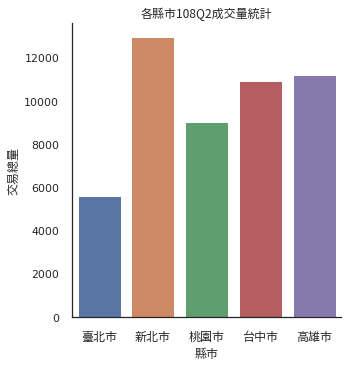

In [272]:
from google.colab import files
sns.set(style = "white")
sns.catplot(x="city", kind="count", data=data)
plt.title("各縣市108Q2成交量統計",fontProperties = zh_font)
plt.xticks(fontProperties = zh_font)
plt.xlabel("縣市", fontProperties = zh_font)
plt.ylabel("交易總量", fontProperties = zh_font) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

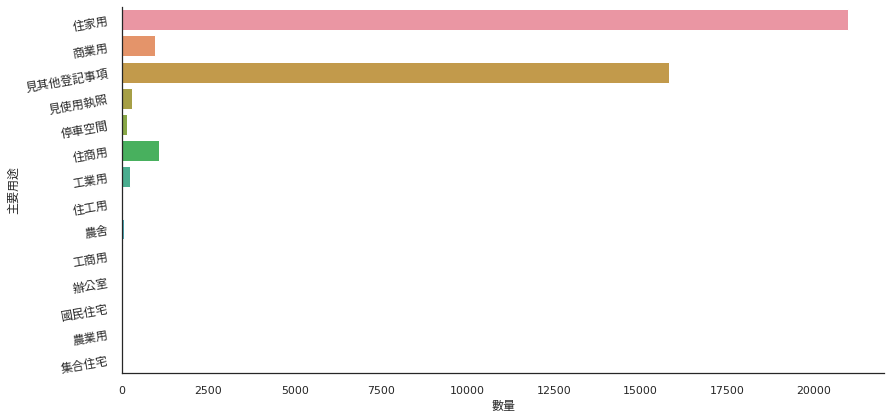

In [274]:
sns.set(style = "white")
sns.catplot(y="主要用途", kind="count", data=data, height=6, aspect=2)
plt.yticks(fontProperties = zh_font, rotation = 10)
plt.xlabel("數量", fontProperties = zh_font)
plt.ylabel("主要用途", fontProperties = zh_font) 
plt.savefig('txn_reason.png')
files.download("txn_reason.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

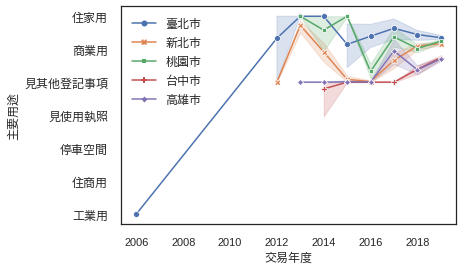

In [275]:
sns.lineplot(x="year", y="主要用途",hue="city", data=data, style="city", 
            markers=True, dashes=False, ci=100)
plt.style.use('seaborn') 
plt.legend(prop=zh_font)
plt.yticks(fontProperties = zh_font)
plt.xlabel("交易年度", fontProperties = zh_font)
plt.ylabel("主要用途", fontProperties = zh_font) 
plt.savefig('city_txn_reason.png')
files.download("city_txn_reason.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

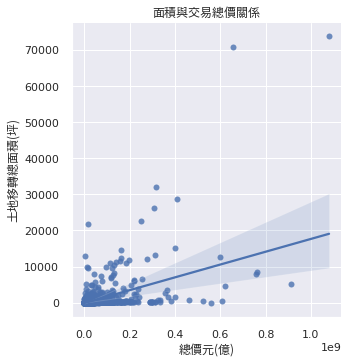

In [281]:
sns.set_theme(color_codes=True)
data2 = data[data['總價元'] !=None]
data2 = data[data['土地移轉總面積(坪)'] !=None]
data2 = data[(data['主要用途'] == '住家用') | 
             (data['主要用途'] == '商業用') | 
             (data['主要用途'] == '住商用') | 
             (data['主要用途'] == '見其他登記事項')]
sns.lmplot(x="總價元", y="土地移轉總面積(坪)", data=data2)
plt.title('面積與交易總價關係', fontProperties = zh_font)
plt.xlabel("總價元(億)", fontProperties = zh_font)
plt.ylabel("土地移轉總面積(坪)", fontProperties = zh_font)
plt.savefig('price_area_regression_analysis.png')
files.download("price_area_regression_analysis.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

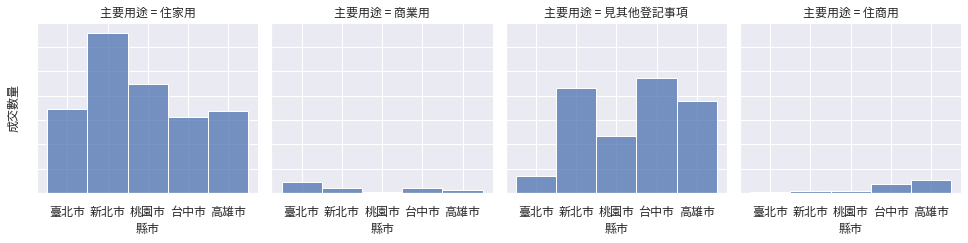

In [284]:
g = sns.FacetGrid(data2, col="主要用途", height=3.5).set_ylabels("成交數量", fontProperties = zh_font)
g.map(sns.histplot, "city").set_xlabels("縣市", fontProperties = zh_font)\
                           .set_xticklabels(fontProperties = zh_font)\
                           .set_yticklabels(fontProperties = zh_font)\
                           .set_titles(fontProperties = zh_font)
plt.savefig('city_top4_txn_reason_analysis.png')
files.download("city_top4_txn_reason_analysis.png") 